This is a notebook on how to use deeplabcut (DLC) to track pupil

Let's import `pupil` first

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pipeline import pupil
import datajoint as dj

Loading local settings from pipeline_config.json


/usr/local/lib/python3.6/dist-packages/deeplabcut/__init__.py:22: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/pla

DLC loaded in light mode; you cannot use the labeling GUI!
DLC loaded in light mode; you cannot use the relabeling GUI!


/usr/local/lib/python3.6/dist-packages/deeplabcut/utils/visualization.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/

Connecting donnie@10.28.0.34:3306


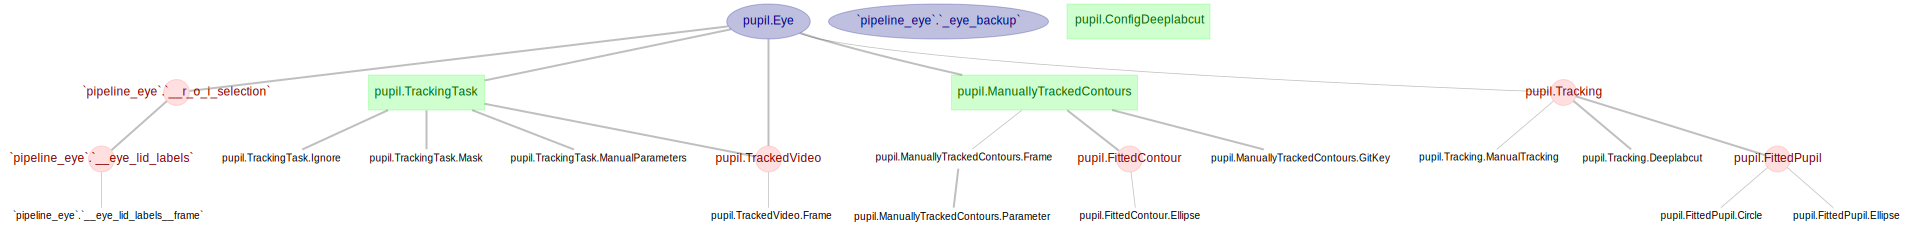

In [3]:
dj.ERD(pupil)

# Tracking the pupil

In order to track pupil, first we need to specify the following:

- animal_id
- session
- scan_idx
- tracking_method

where tracking_method being **0** for manual tracking, and __1__ for deeplabcut tracking. To see different methods, one can see from _shared.py_ module

In [4]:
from pipeline import shared
shared.TrackingMethod()

tracking_method method used for pupil tracking,name short name to identify the tracking method,details more details,language implementation language
1,manual,manually tracking,python
2,deeplabcut,automatically tracking using deeplabcut package,python


Now, let's populate some cases with deeplabcut method. Let's define our key:

In [5]:
key = dict(animal_id=21617, session=9, scan_idx=7, tracking_method=2) # modify the values here

For tracking method, there are 2 methods currently:
- Manual == 1
- deeplabcut == 2

Note, manual (i.e. `tracking_method` as 1) is now depcrecated. Only the ones that are ALREADY contoured will be able to fetch data from `ManuallyTrackedContours`. Otherwise, it will throw an error down the stream. So make sure you use 2 for automatic labeling

Now, to track it using the deeplabcut, simply call the following:

In [6]:
# pupil.Tracking.populate(key)

Once successfully populated, you can check the part tables

In [7]:
pupil.Tracking()

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,tracking_method method used for pupil tracking,tracking_ts automatic
21617,9,7,2,2019-05-21 15:39:00


In [8]:
pupil.Tracking.Deeplabcut()

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,tracking_method method used for pupil tracking,short_vid_starting_index middle frame index of the original video,cropped_x0 start width coord wrt original video,cropped_x1 end width coord wrt original video,cropped_y0 start height coord wrt original video,cropped_y1 end height coord wrt original video,added_pixels number of pixels added around the cropping coords,config_path path to deeplabcut config yaml
21617,9,7,2,66090,650,1056,350,666,100,/mnt/lab/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml


In [9]:
pupil.Tracking.ManualTracking()

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,tracking_method method used for pupil tracking,frame_id frame id (starting from 0),contour eye contour relative to ROI


As expected, `ManualTracking` part table is empty while `Deeplabcut` part table is filled. one can check what each entry means. For detailed explanation on HOW the procedure goes, please check `DLC_workflow_detailed_explanation.ipynb`. This page is simply about how to populate tables.

For secondary key attributes, we can execute `heading`

In [10]:
pupil.Tracking.Deeplabcut.heading

# 
animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
tracking_method      : tinyint                      # method used for pupil tracking
---
short_vid_starting_index : int unsigned                 # middle frame index of the original video
cropped_x0           : smallint unsigned            # start width coord wrt original video
cropped_x1           : smallint unsigned            # end width coord wrt original video
cropped_y0           : smallint unsigned            # start height coord wrt original video
cropped_y1           : smallint unsigned            # end height coord wrt original video
added_pixels         : smallint unsigned            # number of pixels added around the cropping coords
config_path          : varchar(128)                 # path to deeplabcut config yaml

Now that we have tracked successfully, we can fit both a circle and ellipse.

# Fitting contour to the tracked video

Once tracked, then we can fit both a `circle` and an `ellipse` to the tracked video

In [11]:
# pupil.FittedPupil().populate(key)

In [12]:
pupil.FittedPupil & key

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,tracking_method method used for pupil tracking,fitting_ts automatic
21617,9,7,2,2019-05-21 16:47:28


In [13]:
pupil.FittedPupil.Circle & key

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,tracking_method method used for pupil tracking,frame_id frame id with matlab based 1 indexing,"center center of the circle in (x, y) of image",radius radius of the circle,visible_portion portion of visible pupil area given a fitted circle frame. Please refer DLC_tools.PupilFitting.detect_visible_pupil_area for more details
21617,9,7,2,0,=BLOB=,nan,-3.0
21617,9,7,2,1,=BLOB=,nan,-3.0
21617,9,7,2,2,=BLOB=,nan,-3.0
21617,9,7,2,3,=BLOB=,nan,-3.0
21617,9,7,2,4,=BLOB=,nan,-3.0
21617,9,7,2,5,=BLOB=,nan,-3.0
21617,9,7,2,6,=BLOB=,nan,-3.0
21617,9,7,2,7,=BLOB=,nan,-3.0
21617,9,7,2,8,=BLOB=,nan,-3.0
21617,9,7,2,9,=BLOB=,nan,-3.0


In [14]:
pupil.FittedPupil.Ellipse & key

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,tracking_method method used for pupil tracking,frame_id frame id with matlab based 1 indexing,"center center of the ellipse in (x, y) of image",major_radius major radius of the ellipse,minor_radius minor radius of the ellipse,rotation_angle ellipse rotation angle in degrees w.r.t. major_radius,visible_portion portion of visible pupil area given a fitted ellipse frame. Please refer DLC_tools.PupilFitting.detect_visible_pupil_area for more details
21617,9,7,2,0,=BLOB=,nan,nan,nan,-3.0
21617,9,7,2,1,=BLOB=,nan,nan,nan,-3.0
21617,9,7,2,2,=BLOB=,nan,nan,nan,-3.0
21617,9,7,2,3,=BLOB=,nan,nan,nan,-3.0
21617,9,7,2,4,=BLOB=,nan,nan,nan,-3.0
21617,9,7,2,5,=BLOB=,nan,nan,nan,-3.0
21617,9,7,2,6,=BLOB=,nan,nan,nan,-3.0
21617,9,7,2,7,=BLOB=,nan,nan,nan,-3.0
21617,9,7,2,8,=BLOB=,nan,nan,nan,-3.0
21617,9,7,2,9,=BLOB=,nan,nan,nan,-3.0


# Retreiving fitted info

In [15]:
r, center_circle = (pupil.FittedPupil.Circle() & key).fetch('radius', 'center', order_by='frame_id ASC')

In [16]:
major_r, minor_r, center_ellipse = (pupil.FittedPupil.Ellipse() & key).fetch('major_radius', 'minor_radius', 'center', order_by='frame_id ASC')

# Checking the fitted frame (DEEPLABCUT only)

If one wants to see how well DLC predicted and how well the fitting proceeded, one can easily check. First, import the following:

In [17]:
from deeplabcut.utils import auxiliaryfunctions
from pipeline.utils import DLC_tools

In [18]:
shuffle, trainingsetindex = (pupil.ConfigDeeplabcut & key).fetch1(
    'shuffle', 'trainingsetindex')
cc_info = (pupil.Tracking.Deeplabcut & key).fetch1()

config = auxiliaryfunctions.read_config(cc_info['config_path'])
config['config_path'] = cc_info['config_path']
config['shuffle'] = shuffle
config['trainingsetindex'] = trainingsetindex

#find path to compressed/cropped video
import os
vid_path = pupil.Tracking.Deeplabcut().get_video_path(key)
vid_dir = os.path.dirname(os.path.normpath(vid_path))
base_name = os.path.basename(os.path.normpath(vid_path)).split('.')[0]
cc_vid_path = os.path.join(vid_dir,base_name + '_tracking','compressed_cropped', base_name + '_compressed_cropped.avi')

config['video_path'] = cc_vid_path

Now, we instantiate `DLC_tools.PupilFitting`. It takes `config` and `bodyparts` as parameters. If we pass `all` for `bodyparts`, we then plot every label. Otherwise, we can specify a list of bodyparts in `string` format. The available bodyparts are the following:
- 'eyelid_top'
- 'eyelid_top_right'
- 'eyelid_right' 
- 'eyelid_right_bottom'
- 'eyelid_bottom'
- 'eyelid_bottom_left'
- 'eyelid_left'
- 'eyelid_left_top'
- 'pupil_top'
- 'pupil_top_right'
- 'pupil_right'
- 'pupil_right_bottom'
- 'pupil_bottom'
- 'pupil_bottom_left'
- 'pupil_left'
- 'pupil_left_top'

Or you can also see the list by calling `config['bodyparts']`

In [19]:
pupil_fit = DLC_tools.PupilFitting(config=config, bodyparts='all')

132181


Now, we can plot one specific frame with either `circle` fitting or `ellipse` fitting

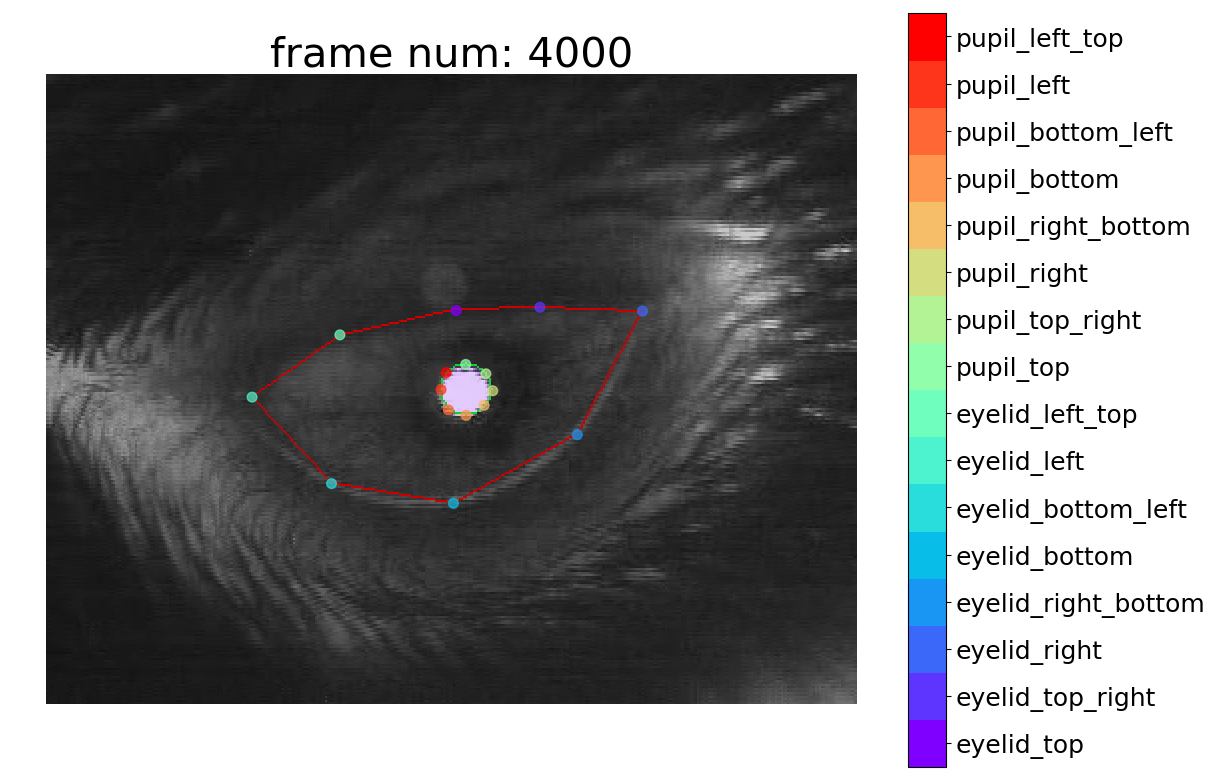

In [20]:
pupil_fit.plot_fitted_frame(frame_num=4000, fitting_method='circle')

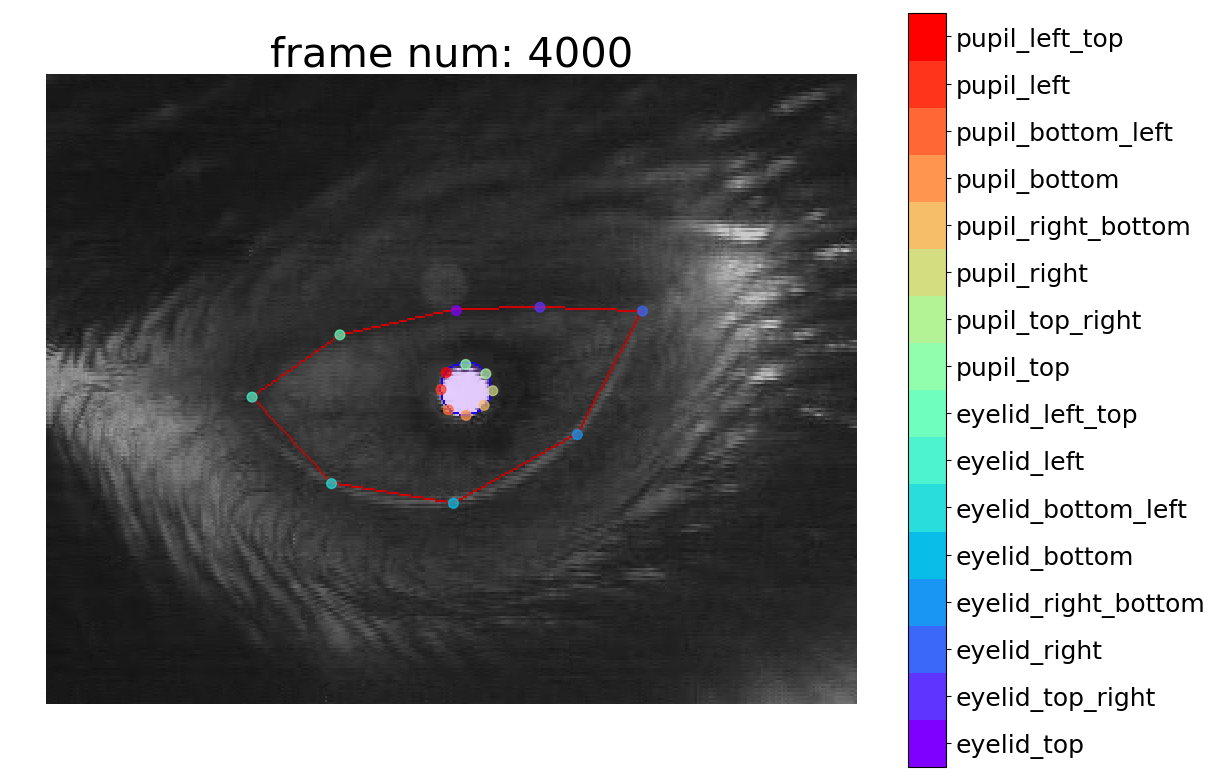

In [21]:
pupil_fit.plot_fitted_frame(frame_num=4000, fitting_method='ellipse')

Or you can plot multiple frames

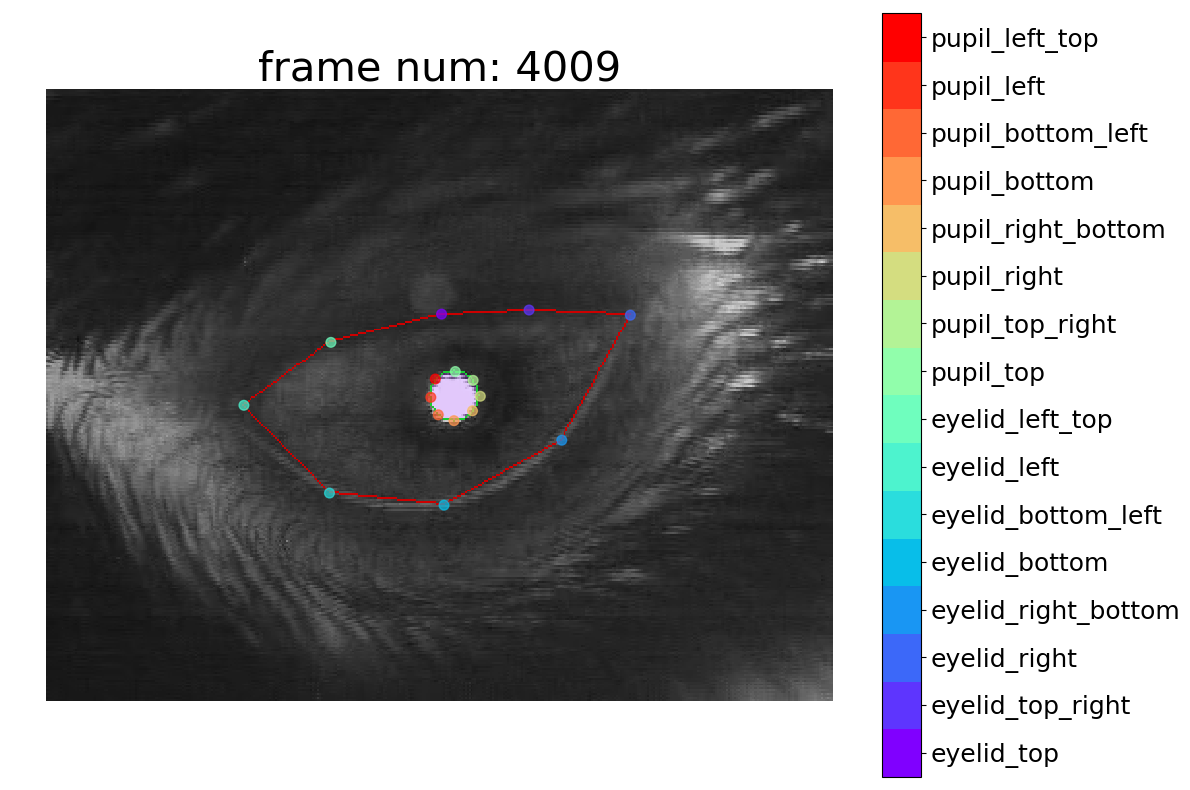

In [23]:
pupil_fit.plot_fitted_multi_frames(start=4000, end=4010, fitting_method='circle')

For more information on `PupilFitting`, please use `DLC_tools.PupilFitting??` and `DLC_tools.PlotBodyparts??`

In [47]:
# DLC_tools.PupilFitting??
# DLC_tools.PlotBodyparts??